In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# The Task
Train several models of recurrent neural networks, for example LSTM, GRU, Bidirectional-LSTM.
Calculate the value of the metric that you proposed in Part 1 and compare the results for different RN, heuristics, and classical ML.

### Read the preprocessed data

In [2]:
data = pd.read_parquet('data/Tweets.parquet', engine='pyarrow')

### Check the loaded data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41128 entries, 1 to 41156
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Text             41128 non-null  object
 1   Sentiment        41128 non-null  object
 2   Text_Length      41128 non-null  int64 
 3   Normalized_Text  41128 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.6+ MB


In [4]:
data.sample(10)

,Text,Sentiment,Text_Length,Normalized_Text
1373,#NY wilding rn ?? #coronavirus #nofood https:/...,Neutral,62,ny wild rn coronaviru nofood
3933,staying home and shopping online?\r\r\nFor a l...,Negative,303,stay home shop onlin limit time get 15 phone a...
11457,"Be vigilant on the internet and with emails, p...",Positive,263,vigil internet email practic selfprotect measu...
2554,Coronavirus: Food banks forced to close amid C...,Extremely Negative,270,coronaviru food bank forc close amid covid19 o...
19735,Welp... thatÂs a wrap!! Good day folks!! #cor...,Positive,208,welp thatâ wrap good day folk corona coronavi...
32309,Over the past year we ve called for an end to ...,Extremely Negative,232,past year call end irrespons way us handl plas...
4625,Avoid any consumer discretionary stocks.\r\r\n...,Extremely Negative,176,avoid consum discretionari stock airlin go ban...
15098,"@Tesco Musselburgh, East Lothian. Why do you f...",Negative,192,musselburgh east lothian feel need increas pri...
18885,I ve gotten an email from every retail store a...,Neutral,124,gotten email everi retail store app restaur co...
38242,Novel #consumer protection #lawsuit filed agai...,Positive,257,novel consum protect lawsuit file fox news was...


Everethig looks fine, so we can start to train our models.

# LSTM
Let's start with  LSTM with pytorch.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data import get_tokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [6]:
tokenizer = get_tokenizer("spacy")

/home/dzailz/urfu/NLP/.venv/lib/python3.11/site-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [7]:
# Tokenization and text preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(tokens)

In [8]:

# Apply preprocessing to the 'Text' column
data['Processed_Text'] = data['Normalized_Text'].apply(preprocess_text)

In [9]:
# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
data['Sentiment_encoded'] = label_encoder.fit_transform(data['Sentiment'])

In [10]:
# Split the data into train, test, and validation sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)


In [11]:
# Vectorize the text data
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(train_df['Normalized_Text'])
X_test_vec = vectorizer.transform(test_df['Normalized_Text'])
X_valid_vec = vectorizer.transform(valid_df['Normalized_Text'])

In [12]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_vec.toarray(), dtype=torch.float32)


In [13]:
# Convert labels to PyTorch tensors
y_train_tensor = torch.tensor(train_df['Sentiment_encoded'].values, dtype=torch.long)
y_test_tensor = torch.tensor(test_df['Sentiment_encoded'].values, dtype=torch.long)
y_valid_tensor = torch.tensor(valid_df['Sentiment_encoded'].values, dtype=torch.long)

In [14]:
# Assuming you have a multi-label model, modify the output dimension accordingly
output_dim = len(data['Sentiment_encoded'].unique())

In [15]:
# Instantiate the model with dropout
class MultiLabelModelWithDropout(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.5):
        super(MultiLabelModelWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x  # No sigmoid activation here

In [16]:
# Instantiate the model with dropout
model = MultiLabelModelWithDropout(input_dim=X_train_tensor.shape[1], output_dim=output_dim, dropout_rate=0.5)

In [17]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Experiment with different learning rates

In [18]:
# Training loop with dropout and validation
num_epochs = 100
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    
    # Add L2 regularization
    l2_reg = 0.001
    for param in model.parameters():
        loss += l2_reg * torch.sum(param.pow(2))
    
    loss.backward()
    optimizer.step()
    
    # Append the training loss for visualization
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        predictions_valid = model(X_valid_tensor)
        loss_valid = criterion(predictions_valid, y_valid_tensor)
        valid_losses.append(loss_valid.item())

    # Print and visualize the training and validation losses
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Valid Loss: {loss_valid.item():.4f}")


Epoch [1/100], Train Loss: 1.6994, Valid Loss: 1.6030
Epoch [2/100], Train Loss: 1.6531, Valid Loss: 1.5929
Epoch [3/100], Train Loss: 1.6190, Valid Loss: 1.5818
Epoch [4/100], Train Loss: 1.5938, Valid Loss: 1.5702
Epoch [5/100], Train Loss: 1.5758, Valid Loss: 1.5586
Epoch [6/100], Train Loss: 1.5626, Valid Loss: 1.5473
Epoch [7/100], Train Loss: 1.5521, Valid Loss: 1.5363
Epoch [8/100], Train Loss: 1.5434, Valid Loss: 1.5258
Epoch [9/100], Train Loss: 1.5348, Valid Loss: 1.5156
Epoch [10/100], Train Loss: 1.5256, Valid Loss: 1.5056
Epoch [11/100], Train Loss: 1.5163, Valid Loss: 1.4956
Epoch [12/100], Train Loss: 1.5051, Valid Loss: 1.4855
Epoch [13/100], Train Loss: 1.4953, Valid Loss: 1.4753
Epoch [14/100], Train Loss: 1.4837, Valid Loss: 1.4650
Epoch [15/100], Train Loss: 1.4733, Valid Loss: 1.4545
Epoch [16/100], Train Loss: 1.4606, Valid Loss: 1.4440
Epoch [17/100], Train Loss: 1.4504, Valid Loss: 1.4336
Epoch [18/100], Train Loss: 1.4404, Valid Loss: 1.4232
Epoch [19/100], Tra

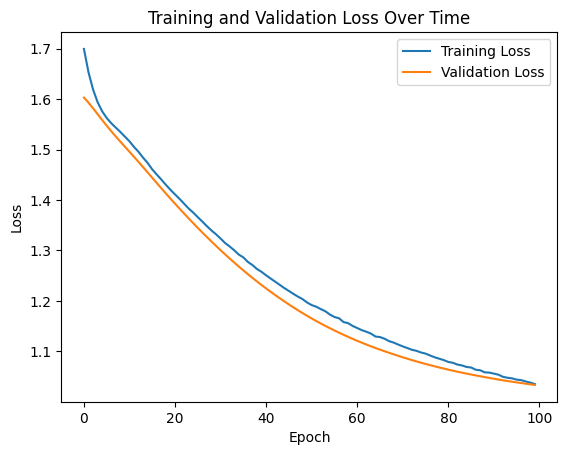

In [19]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [20]:
# Evaluation loop and metric calculation on the test set
model.eval()
with torch.no_grad():
    predictions_test = model(X_test_tensor)
    probabilities_test = F.softmax(predictions_test, dim=1)
    _, predicted_labels_test = torch.max(probabilities_test, 1)


In [21]:
# Calculate metrics on the test set
roc_auc_test = roc_auc_score(y_test_tensor, probabilities_test, multi_class='ovr', average='macro')
f1_test = f1_score(y_test_tensor, predicted_labels_test, average='macro')

print(f"Test ROC AUC: {roc_auc_test:.4f}, Test F1 Score: {f1_test:.4f}")

Test ROC AUC: 0.8611, Test F1 Score: 0.5940
